# 0. Гипотезы

1. дополнительно удалить access, interaction, house_rules, host_response_time
2. предобработать пропуски
3. расстояние до центра лондона
4. security_deposit, cleaning_fee заменить на среднее
5. neighbourhood_cleansed не удалять

# 1. Загрузка библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import folium
from folium.plugins import HeatMap
from geopy.distance import great_circle

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, log_loss, make_scorer

from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit,\
                                    validation_curve, learning_curve, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler,\
                                    FunctionTransformer, PowerTransformer, PolynomialFeatures


from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, BayesianRidge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 2. Загрузка данных

Loading data

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
train2_df = pd.read_csv("listings.csv")

In [4]:
train_df.head(2)

id                                               name  \
0  127860  Double bedroom in cottage Twickenham (sleeps 1-2)   
1  325809                Big House for Olympics sleeps 6 to8   

                                             summary  \
0  One gorgeous, light-filled double bedroom (sle...   
1                                                NaN   

                                               space  \
0  A beautiful, light-filled double bedroom is ou...   
1  A beautiful, modern, art-filled and clean 4 st...   

                                         description experiences_offered  \
0  One gorgeous, light-filled double bedroom (sle...                none   
1  A beautiful, modern, art-filled and clean 4 st...                none   

                               neighborhood_overview  \
0  Very, very safe area, great transport links an...   
1                                                NaN   

                          notes  \
0  We have a super-gorgeous cat   
1                           NaN   

                                             transit  \
0  Twickenham Rugby Stadium is 15 mins walk Water...   
1                                                NaN   

                                              access  ... square_feet  \
0  You'll have full use of the cottage, two recep...  ...         NaN   
1                                                NaN  ...      1400.0   

  security_deposit  cleaning_fee guests_included extra_people minimum_nights  \
0            300.0          10.0               1         10.0              2   
1            771.0           NaN               1          0.0             14   

           cancellation_policy require_guest_profile_picture  \
0  strict_14_with_grace_period                             f   
1  strict_14_with_grace_period                             f   

  require_guest_phone_verification   price  
0                                f  1000.0  
1                                f   771.0  

[2 rows x 43 columns]

In [5]:
train_columns = train_df.columns.to_list() #наименование колонок в трейне
test_columns = test_df.columns.to_list() #наименование колонок в тесте

In [6]:
train_df.shape, test_df.shape # размер трейна и теста

((51815, 43), (23000, 42))

In [7]:
dif_train_test_columns = (set(train_columns) - set(test_columns))
dif_train_test_columns

{'price'}

Фичи в трейне и тесте совпадают. Проверим пропущенные значения цены

In [8]:
train_df.describe()

id       host_id      latitude     longitude  accommodates  \
count  5.181500e+04  5.181500e+04  51815.000000  51815.000000  51815.000000   
mean   2.238119e+07  8.122630e+07     51.509058     -0.127937      3.225089   
std    4.648209e+06  6.712667e+07      0.045575      0.092781      2.002458   
min    1.278600e+05  4.775000e+03     51.294794     -0.501305      1.000000   
25%    1.874920e+07  2.049720e+07     51.486162     -0.187733      2.000000   
50%    2.235012e+07  6.358767e+07     51.513346     -0.126478      2.000000   
75%    2.655883e+07  1.362233e+08     51.535516     -0.070239      4.000000   
max    2.979850e+07  2.241824e+08     51.679199      0.285395     20.000000   

          bathrooms      bedrooms          beds  square_feet  \
count  51812.000000  51796.000000  51743.000000    15.000000   
mean       1.294227      1.399027      1.773438   991.133333   
std        0.620269      0.907317      1.224066   933.178965   
min        0.000000      0.000000      0.000000     0.000000   
25%        1.000000      1.000000      1.000000   242.000000   
50%        1.000000      1.000000      1.000000   753.000000   
75%        1.500000      2.000000      2.000000  1600.000000   
max       14.000000     12.000000     16.000000  3000.000000   

       security_deposit  cleaning_fee  guests_included  extra_people  \
count      33897.000000  38364.000000     51815.000000  51815.000000   
mean         192.249019     42.472891         1.561401      7.052359   
std          310.090851     44.525508         1.282639     13.353841   
min            0.000000      0.000000         1.000000      0.000000   
25%            0.000000     15.000000         1.000000      0.000000   
50%          100.000000     30.000000         1.000000      0.000000   
75%          250.000000     60.000000         2.000000     10.000000   
max         4098.000000    614.000000        30.000000    235.000000   

       minimum_nights         price  
count    51815.000000  51815.000000  
mean         3.959548    115.015787  
std         13.994390    201.599587  
min          1.000000      0.000000  
25%          1.000000     45.000000  
50%          2.000000     80.000000  
75%          3.000000    135.000000  
max       1125.000000  13700.000000

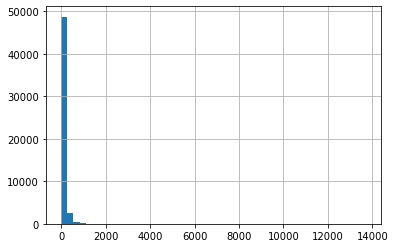

In [9]:
train_df['price'].hist(bins=50)

В трейнне есть позиции с нулевой ценой, средняя цена составляет 115, а максимальная 13700. Удалим 

In [10]:
idx_zero = train_df[train_df['price'] <= 5].index # позиции с значением меньше 5
idx_large = train_df[train_df['price'] > 2000].index # позиции с значением больше 2000

In [11]:
train_wo_min = train_df.drop(idx_zero)
train_wo_min_max = train_wo_min.drop(idx_large)

split_value = len(train_wo_min_max) # размер нашего трейна
print(split_value)

51732


In [12]:
target = train_wo_min_max['price'] # наш таргет

##### Объеденим трейн и тест

In [13]:
airbnb = pd.concat([train_wo_min_max.drop('price', axis=1), test_df])

# 3. Обработка признаков

In [14]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74732 entries, 0 to 22999
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                74732 non-null  int64  
 1   name                              74702 non-null  object 
 2   summary                           71829 non-null  object 
 3   space                             50972 non-null  object 
 4   description                       73704 non-null  object 
 5   experiences_offered               74732 non-null  object 
 6   neighborhood_overview             45439 non-null  object 
 7   notes                             29670 non-null  object 
 8   transit                           45611 non-null  object 
 9   access                            43503 non-null  object 
 10  interaction                       41394 non-null  object 
 11  house_rules                       44041 non-null  object 
 12  host

### Подробнее о фичах

- 0   id                             - айди пользователя (удалить)
- 1   name                           - имя пользователя (удалить)
- 2   summary - резюме (удалить)                         
- 3   space - описание местности (удалить)                           
- 4   description - описание квартиры (удалить)                     
- 5   experiences_offered - семейный, бизнес, романтический, общественный, ноун (удалить)
- 6   neighborhood_overview - описание чего-то, слишком много пропусков (удалить)           
- 7   notes - заметки, слишком много пропусков (удалить)                            
- 8   transit - описание чего-то (удалить)                         
- 9   access - описание чего-то (удалить)                       
- 10  interaction - как обращаться к владельцу: по телефону, емейлу (удалить)                 
- 11  house_rules - правила дома (удалить)                 
- 12  host_id - айди владельца (удалить)                         
- 13  host_since - сдается с (непонятно)                 
- 14  host_about - информация о владельце (удалить)                    
- 15  host_response_time - насколько сдается квартира (непонятно)         
- 16  host_response_rate - частота сдачи квартиры (непонятно)               
- 17  host_is_superhost - что то типа статуса владельца (непонятно)                
- 18  host_has_profile_pic - есть фото владельца (непонятно)            
- 19  host_identity_verified - подвержденная идентификация (непонятно)             
- 20  neighbourhood_cleansed - район Лондона            
- 21  zipcode - какой-то код (удалить)                         
- 22  latitude - координата                        
- 23  longitude - координата                      
- 24  is_location_exact - точное местоположение (удалить)                
- 25  property_type - тип квартиры                    
- 26  room_type - еще один тип квариры                         
- 27  accommodates - вместимость                        
- 28  bathrooms - количество ванных               
- 29  bedrooms - количество спален                     
- 30  beds - количество кроватей                        
- 31  bed_type - тип кроватей                      
- 32  amenities - наличие ТВ, интернета и тд                  
- 33  square_feet - площадь кв, много пропусков (удалить)                 
- 34  security_deposit - депозит (непонятно)            
- 35  cleaning_fee - плата за уборку                  
- 36  guests_included - можно ли с гостями                
- 37  extra_people - дополнительные люди, нет пропусков (непонятно)                   
- 38  minimum_nights - минимальное количество ночей, нет пропусков (непонятно)             
- 39  cancellation_policy - политика отмены брони (непонятно)             
- 40  require_guest_profile_picture - требование фото пользователя   
- 41  require_guest_phone_verification - требование подтверждение пользователя

Удалим лишние фичи

In [15]:
# удаление ненужных столбцов
columns_to_drop = ['id', 'host_id', 'access', 'house_rules', 'interaction',
                   'name', 'summary', 'space', 'description',
                   'experiences_offered', 'neighbourhood_cleansed', 'zipcode',
                   'neighborhood_overview', 'notes', 'transit', 'host_about',
                   'square_feet']

airbnb.drop(columns=columns_to_drop, inplace=True)

In [16]:
aaaa =airbnb.columns.to_list()
airbnb2 = train2_df[aaaa]

### Обработка признаков

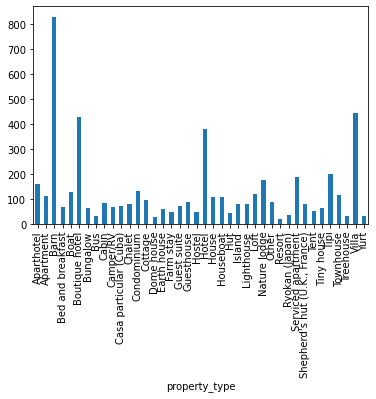

In [17]:
train_df.groupby("property_type")["price"].mean().plot(kind="bar") # тип сдаваемого помещения от цены

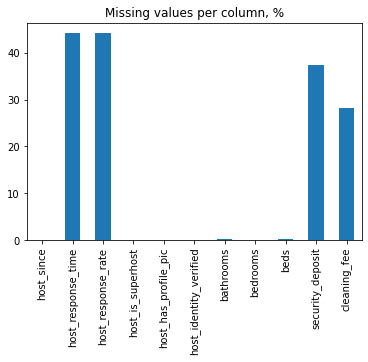

In [18]:
#найдем процент пропущенных значений в каждом столбце
listings_missing_df = airbnb.isnull().mean()*100

#колонки, с пропущенными значениями
listings_columns_with_nan = listings_missing_df[listings_missing_df > 0]

#отобразим
listings_columns_with_nan.plot.bar(title='Missing values per column, %')

*возможно также стоит выкинуть host_response_rate, host_response_time

т.к. мы дополнили трейн тестом, то процент увеличился

In [19]:
# Функции для чистки датасета

def get_month_from_date(row):
    ''' Get month from date represented as a string '''
    return int(row['date'].split('-')[1])

def get_year_from_date(row):
    ''' Get year from date represented as a string '''
    return int(row['date'].split('-')[0])

def get_host_since_year(row):
    ''' Get year from a date represented as a string '''
    try:
        host_since = int(row['host_since'].split('-')[0])
    except:
        host_since = np.nan
    return host_since

def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val

def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

def get_extra_people_fee(row):
    ''' Return 1 when the is fee for exatra people '''
    if row['extra_people'] == '$0.00':
        return 0.0
    else:
        return 1.0



##### переделаем host_since в число и почистим пропущенные значения

In [20]:
airbnb['host_since_year'] = airbnb.apply(lambda row: get_host_since_year(row),axis=1)
airbnb['host_since_year'].fillna(round(airbnb['host_since_year'].mean()), inplace = True)
airbnb = airbnb.drop(columns = ['host_since'])

Возможно следует удалить host_response_rate

In [21]:
######
airbnb2['host_since_year'] = airbnb2.apply(lambda row: get_host_since_year(row),axis=1)
airbnb2['host_since_year'].fillna(round(airbnb2['host_since_year'].mean()), inplace = True)
airbnb2 = airbnb2.drop(columns = ['host_since'])

##### переведем host_response_rate в число и почистим пропущенные значения

In [22]:
#переведем host_response_rate в число и почистим пропущенные значения
airbnb['host_response_rate_num'] = airbnb['host_response_rate'].astype(str)
airbnb['host_response_rate_num'] = airbnb['host_response_rate_num'].str.replace("%", "").astype("float")
airbnb['host_response_rate_num'].fillna(airbnb['host_response_rate_num'].mean(), inplace = True)

airbnb['host_response_rate_buckets'] = pd.qcut(airbnb['host_response_rate_num'], 5, labels=False, duplicates = 'drop')

airbnb = airbnb.drop(columns = ['host_response_rate'])

In [23]:
#####
airbnb2['host_response_rate_num'] = airbnb2['host_response_rate'].astype(str)
airbnb2['host_response_rate_num'] = airbnb2['host_response_rate_num'].str.replace("%", "").astype("float")
airbnb2['host_response_rate_num'].fillna(airbnb2['host_response_rate_num'].mean(), inplace = True)

airbnb2['host_response_rate_buckets'] = pd.qcut(airbnb2['host_response_rate_num'], 5, labels=False, duplicates = 'drop')

airbnb2 = airbnb2.drop(columns = ['host_response_rate'])

##### заменить значения у bathrooms, bedrooms и beds на моду

In [24]:
airbnb['bathrooms'] = airbnb['bathrooms'].fillna(airbnb['bathrooms'].mode()[0])
airbnb['bedrooms'] = airbnb['bedrooms'].fillna(airbnb['bedrooms'].mode()[0])
airbnb['beds'] = airbnb['beds'].fillna(airbnb['beds'].mode()[0])

In [25]:
#####
airbnb2['bathrooms'] = airbnb2['bathrooms'].fillna(airbnb2['bathrooms'].mode()[0])
airbnb2['bedrooms'] = airbnb2['bedrooms'].fillna(airbnb2['bedrooms'].mode()[0])
airbnb2['beds'] = airbnb2['beds'].fillna(airbnb2['beds'].mode()[0])

##### сплит amenities в dummy

In [26]:
airbnb['amenities'].unique()

array(['{TV,"Cable TV",Internet,Wifi,Kitchen,Breakfast,"Pets live on this property",Cat(s),"Free street parking","Indoor fireplace",Heating,"Family/kid friendly",Washer,"Smoke detector","Carbon monoxide detector","First aid kit",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}',
       '{"Cable TV",Internet,Wifi,Kitchen,"Free parking on premises","Washer / Dryer",Heating,"Family/kid friendly","Suitable for events",Washer,Dryer}',
       '{TV,Internet,Wifi,Kitchen,"Free parking on premises","Buzzer/wireless intercom",Heating,"Family/kid friendly",Washer,"Smoke detector","Carbon monoxide detector","Fire extinguisher"}',
       ...,
       '{TV,Wifi,Kitchen,"Free parking on premises","Indoor fireplace",Heating,"Family/kid friendly",Washer,Dryer,"Smoke detector","Carbon monoxide detector",Essentials,Shampoo,Hangers,"Hair dryer",Iron}',
       '{TV,"Cable TV",Internet,Wifi,Kitchen,"Free parking on premises",Heating,"Family/kid friendly",Washer,"Sm

In [27]:
split_list_into_columns(airbnb, 'amenities')
airbnb = airbnb.drop(columns = ['amenities'])

In [28]:
#####
split_list_into_columns(airbnb2, 'amenities')
airbnb2 = airbnb2.drop(columns = ['amenities'])

In [29]:
airbnb.head(2)

host_response_time host_is_superhost host_has_profile_pic  \
0                NaN                 f                    t   
1                NaN                 f                    t   

  host_identity_verified   latitude  longitude is_location_exact  \
0                      t  51.447147  -0.339253                 t   
1                      f  51.549993  -0.184546                 t   

  property_type        room_type  accommodates  ...  amenities_Wifi  \
0         House     Private room             2  ...             1.0   
1         House  Entire home/apt             8  ...             1.0   

   amenities_Heating  amenities_Essentials amenities_Kitchen  \
0                1.0                   1.0               1.0   
1                1.0                   0.0               1.0   

   amenities_Washer  amenities_Smoke detector  amenities_Hangers  \
0               1.0                       1.0                1.0   
1               1.0                       0.0                0.0   

   amenities_Iron  amenities_Hair dryer amenities_TV  
0             1.0                   1.0          1.0  
1             0.0                   0.0          0.0  

[2 rows x 35 columns]

##### extra_people

оставим как есть, но можно переделать в бинарные признаки

In [30]:
airbnb['extra_people'].unique()

array([ 10.,   0., 100.,  50.,  25., 230.,  15.,  75.,   8.,  20.,  30.,
        45.,  35.,   5.,   6.,   9.,  40.,  14.,  13.,  12.,  16.,   7.,
         4.,  28.,  39., 120.,  60.,  17.,  18., 200.,  19.,  90.,  29.,
        70.,  59.,  11.,  21.,  80., 210.,  22.,  24.,  55., 170.,  38.,
       160.,  23.,  37.,  31.,  36.,  33.,  65., 150.,  51.,  49.,  26.,
        27., 125.,  32., 232., 222.,  47., 110., 233.,  85., 226.,  58.,
        42., 235., 155., 228.,  88.,  99.,  43.,  52., 224., 188.,  56.,
       135.,  89., 215.,  41.,  69.,  46.,  48., 223.,  64.,  54., 130.,
        44.,  34., 225.,  79., 229.,  68., 175.,  95.,  57.,  91., 105.,
       195.,  98., 212., 227.,  61.,   3., 231., 193., 221.,  74.])

In [31]:
# airbnb['extra_people_fee'] = airbnb.apply(lambda row: get_extra_people_fee(row),axis=1)
# airbnb = airbnb.drop(columns = ['extra_people'])

##### host_response_time

In [32]:
cat_type = pd.api.types.CategoricalDtype(['not specified', 'within an hour', 'within a few hours', 'within a day', 'a few days or more'])
airbnb['host_response_time'] = airbnb['host_response_time'].fillna('not specified').astype(cat_type)

In [33]:
#####
cat_type = pd.api.types.CategoricalDtype(['not specified', 'within an hour', 'within a few hours', 'within a day', 'a few days or more'])
airbnb2['host_response_time'] = airbnb2['host_response_time'].fillna('not specified').astype(cat_type)

##### host_is_superhost, host_has_profile_pic, host_identity_verified

In [34]:
airbnb['host_identity_verified'].fillna('f', inplace=True)
airbnb['host_is_superhost'].fillna('f', inplace=True)
airbnb['host_has_profile_pic'].fillna('t', inplace=True)

In [35]:
#####
airbnb2['host_identity_verified'].fillna('f', inplace=True)
airbnb2['host_is_superhost'].fillna('f', inplace=True)
airbnb2['host_has_profile_pic'].fillna('t', inplace=True)

In [36]:
binary_cols = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 
               'is_location_exact', 'require_guest_profile_picture', 'require_guest_phone_verification']

In [37]:
airbnb[binary_cols][:4]

host_is_superhost host_has_profile_pic host_identity_verified  \
0                 f                    t                      t   
1                 f                    t                      f   
2                 f                    t                      f   
3                 f                    t                      t   

  is_location_exact require_guest_profile_picture  \
0                 t                             f   
1                 t                             f   
2                 t                             f   
3                 t                             f   

  require_guest_phone_verification  
0                                f  
1                                f  
2                                f  
3                                f

In [38]:
binary_map = {'f': 0, 't': 1}
airbnb[binary_cols] = airbnb[binary_cols].apply(lambda x: x.map(binary_map)).astype(int)

In [39]:
#####
airbnb2[binary_cols] = airbnb2[binary_cols].apply(lambda x: x.map(binary_map)).astype(int)

In [40]:
airbnb[binary_cols][:4]

host_is_superhost  host_has_profile_pic  host_identity_verified  \
0                  0                     1                       1   
1                  0                     1                       0   
2                  0                     1                       0   
3                  0                     1                       1   

   is_location_exact  require_guest_profile_picture  \
0                  1                              0   
1                  1                              0   
2                  1                              0   
3                  1                              0   

   require_guest_phone_verification  
0                                 0  
1                                 0  
2                                 0  
3                                 0

##### Преобразуем категориальные признаки

In [41]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74732 entries, 0 to 22999
Data columns (total 35 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   host_response_time                74732 non-null  category
 1   host_is_superhost                 74732 non-null  int64   
 2   host_has_profile_pic              74732 non-null  int64   
 3   host_identity_verified            74732 non-null  int64   
 4   latitude                          74732 non-null  float64 
 5   longitude                         74732 non-null  float64 
 6   is_location_exact                 74732 non-null  int64   
 7   property_type                     74732 non-null  object  
 8   room_type                         74732 non-null  object  
 9   accommodates                      74732 non-null  int64   
 10  bathrooms                         74732 non-null  float64 
 11  bedrooms                          74732 non-null  floa

In [42]:
#turn categorical columns into dummies
cat_columns = list(airbnb.select_dtypes(include=['object', 'category']).columns)

for col in  cat_columns:
    airbnb = pd.concat([airbnb.drop(col, axis=1), pd.get_dummies(airbnb[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=False)], axis=1)

In [43]:
#####
cat_columns = list(airbnb2.select_dtypes(include=['object', 'category']).columns)

for col in  cat_columns:
    airbnb2 = pd.concat([airbnb2.drop(col, axis=1), pd.get_dummies(airbnb2[col], prefix=col, prefix_sep='_',

                                                         drop_first=True, dummy_na=False)], axis=1)

##### почистим пропущенные значения в security_deposit и cleaning_fee

In [44]:
cols1 = ['security_deposit', 'cleaning_fee']

In [45]:
airbnb['security_deposit'].fillna(airbnb['security_deposit'].median(), inplace = True)
airbnb['cleaning_fee'].fillna(airbnb['cleaning_fee'].median(), inplace = True)

In [49]:
######
# airbnb2['security_deposit'].fillna(airbnb2['security_deposit'].median(), inplace = True)
# airbnb2['cleaning_fee'].fillna(airbnb2['cleaning_fee'].median(), inplace = True)

In [50]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74732 entries, 0 to 22999
Data columns (total 86 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   host_is_superhost                                74732 non-null  int64  
 1   host_has_profile_pic                             74732 non-null  int64  
 2   host_identity_verified                           74732 non-null  int64  
 3   latitude                                         74732 non-null  float64
 4   longitude                                        74732 non-null  float64
 5   is_location_exact                                74732 non-null  int64  
 6   accommodates                                     74732 non-null  int64  
 7   bathrooms                                        74732 non-null  float64
 8   bedrooms                                         74732 non-null  float64
 9   beds                        

##### займемся расстоянием до центра

In [51]:
m=folium.Map([51.5073219, -0.1276474],zoom_start=10)
HeatMap(airbnb[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
display(m)

In [52]:
def distance_to_mid(lat, lon):
    london_centre = (51.5073219, -0.1276474)
    accommodation = (lat, lon)
    return great_circle(london_centre, accommodation).km

In [53]:
airbnb['distance'] = airbnb.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)
airbnb.drop(columns=['latitude', 'longitude'], inplace=True)

In [54]:
airbnb2['distance'] = airbnb2.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)
airbnb2.drop(columns=['latitude', 'longitude'], inplace=True)

##### Разобьем на категориальные и числовые признаки

In [55]:
all_columns = airbnb.columns.to_list()

In [56]:
scaled_columns = ['accommodates', 'bathrooms', 'bedrooms', 'security_deposit', 'cleaning_fee',
                  'host_response_rate_num',
                  'beds', 'guests_included','extra_people', 'minimum_nights', 'host_since_year', 'distance']

In [57]:
other_columns = list(set(all_columns) - set(scaled_columns))

##### трансформируем числовые признаки

In [58]:
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(airbnb[scaled_columns])

In [60]:
#####
# scaler2 = StandardScaler()
# X2_num_scaled = scaler2.fit_transform(airbnb2[scaled_columns])

##### объеденяем с категориальными

In [61]:
X_clean = np.hstack([X_num_scaled, airbnb[other_columns].values])

# Train и Test

In [62]:
#prepare train and test datasets for modelling
TEST_SIZE = 0.3
RAND_STATE = 42

X = X_clean[:len(target)]
test = X_clean[len(target):]
y = target.values
weights = 1/y



In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

# Функции потерь

In [65]:
def adj_r2(R2):
    return (1- ((1-R2) * (x_train.shape[0]-1)/(x_train.shape[0]-x_train.shape[1]-1)))

# def mape(a, p):
#     a = np.array(a).reshape(-1,1)
#     p = np.array(p).reshape(-1,1)
#     return np.mean( np.abs((a - p)/ a) )*100

def mape(y_true, y_pred):
    result = list()
    not_zerro = lambda tp: tp[0] != 0
    for true_i, pred_i in filter(not_zerro, zip(y_true, y_pred)):
        result.append(np.abs((true_i - pred_i)) / true_i)
#     return result
    return np.mean(result) * 100


def RMSLE(a, p):
    a = np.array(a).reshape(-1,1)
    p = np.array(p).reshape(-1,1)
    assert len(p) == len(a)
    return np.sqrt(np.mean( (np.log(p+1) - np.log(a+1))**2 ))

def RMSE(a, p):
    a = np.array(a).reshape(-1,1)
    p = np.array(p).reshape(-1,1)
    return np.sqrt(np.mean((p-a)**2))

In [66]:
mape_score = make_scorer(mape, greater_is_better=False)

# Обучение модели

### LGBMRegressor

In [67]:
lgbm_tune = LGBMRegressor(objective = 'regression',  
                        max_depth = 11,
                        colsample_bytre = 0.8,
                        subsample = 0.8, 
                        learning_rate = 0.1,
                        n_estimators = 300)

In [68]:
lgbm_tune.fit(X, y.squeeze(), 
        sample_weight = weights,
        eval_metric="mape")

[LightGBM] [Warning] Unknown parameter: colsample_bytre
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMRegressor(colsample_bytre=0.8, max_depth=11, n_estimators=300,
              objective='regression', subsample=0.8)

In [69]:
y_train_preds = lgbm_tune.predict(X)
y_test_preds = lgbm_tune.predict(test)

In [70]:
print('LGBMRegressor MSE train: %.3f' % (mean_squared_error(y, y_train_preds)))
print('LGBMRegressor R^2 train: %.3f' % (r2_score(y, y_train_preds)))
print('LGBMRegressor RMSE train: %.3f' % (RMSE(y, y_train_preds)))
print('LGBMRegressor mape train: %.3f' % (mape(y, y_train_preds)))

LGBMRegressor MSE train: 4402.541
LGBMRegressor R^2 train: 0.670
LGBMRegressor RMSE train: 66.352
LGBMRegressor mape train: 23.469


In [71]:
# Кросс-валидация модели
cv = KFold(n_splits = 5, shuffle = True, random_state = 2)
cv_result = cross_val_score(lgbm_tune, X, y, cv = cv, n_jobs = -1, scoring = mape_score, fit_params = {'sample_weight': weights})
print('Результаты кросс-валидации', cv_result, np.mean(cv_result), np.std(cv_result))

Результаты кросс-валидации [-25.94990835 -26.38200769 -26.62120332 -25.78996403 -25.5838289 ] -26.065382456265127 0.38217058548943383


In [72]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["price"] = y_test_preds
sample_submission.to_csv("LGBMR_true.csv", index=False)

### SGDRegressor

In [73]:
# Модели для регрессии
model = SGDRegressor(loss = 'epsilon_insensitive', epsilon = 0, random_state = 2, max_iter = 5000, penalty = 'elasticnet')

# Кросс-валидация модели
cv = KFold(n_splits = 5, shuffle = True, random_state = 2)
cv_result = cross_val_score(model, X, y, cv = cv, n_jobs = -1, scoring = mape_score, fit_params = {'sample_weight': weights})
print('Результаты кросс-валидации', cv_result, np.mean(cv_result), np.std(cv_result))

# Обучаем модель на всей выборке
model.fit(X, y, sample_weight = weights)

Результаты кросс-валидации [-35.07846761 -35.30694573 -35.27794418 -35.2219585  -34.63013671] -35.10309054575043 0.24921955561090275


SGDRegressor(epsilon=0, loss='epsilon_insensitive', max_iter=5000,
             penalty='elasticnet', random_state=2)

In [74]:
y_train_preds = model.predict(X)
y_test_preds = model.predict(test)

In [75]:
print('SGDRegressor MSE train: %.3f' % (mean_squared_error(y, y_train_preds)))
print('SGDRegressor R^2 train: %.3f' % (r2_score(y, y_train_preds)))
print('SGDRegressor RMSE train: %.3f' % (RMSE(y, y_train_preds)))
print('SGDRegressor mape train: %.3f' % (mape(y, np.round(y_train_preds))))

SGDRegressor MSE train: 11264.555
SGDRegressor R^2 train: 0.156
SGDRegressor RMSE train: 106.135
SGDRegressor mape train: 34.897


### CatBoostRegressor

In [76]:
ITERATIONS = 1000
LR = 0.1

In [77]:
cbr_tune = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RAND_STATE)


In [78]:
cbr_tune.fit(X, y.squeeze(), sample_weight=weights, plot=False, verbose=False)

In [79]:
y_train_preds = cbr_tune.predict(X)
y_test_preds = cbr_tune.predict(test)

In [80]:
print('CatBoostRegressor MSE train: %.3f' % (mean_squared_error(y, y_train_preds)))
print('CatBoostRegressor R^2 train: %.3f' % (r2_score(y, y_train_preds)))
print('CatBoostRegressor RMSE train: %.3f' % (RMSE(y, y_train_preds)))
print('CatBoostRegressor mape train: %.3f' % (mape(y, np.round(y_train_preds))))

CatBoostRegressor MSE train: 5179.152
CatBoostRegressor R^2 train: 0.612
CatBoostRegressor RMSE train: 71.966
CatBoostRegressor mape train: 25.313


In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["price"] = y_test_preds

### XGBRegressor

In [81]:
xgb_tune = XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.03, 
                           max_depth=6, n_estimators=500, random_state=RAND_STATE)

In [82]:
xgb_tune.fit(X, y.squeeze(), sample_weight=weights)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
y_train_preds = xgb_tune.predict(X)
y_test_preds = xgb_tune.predict(test)

In [84]:
print('XGBRegressor MSE train: %.3f' % (mean_squared_error(y, y_train_preds)))
print('XGBRegressor R^2 train: %.3f' % (r2_score(y, y_train_preds)))
print('XGBRegressor RMSE train: %.3f' % (RMSE(y, y_train_preds)))
print('CXGBRegressor mape train: %.3f' % (mape(y, np.round(y_train_preds))))

XGBRegressor MSE train: 6463.548
XGBRegressor R^2 train: 0.516
XGBRegressor RMSE train: 80.396
CXGBRegressor mape train: 25.977


### GradientBoostingRegressor

In [85]:
gb_default = GradientBoostingRegressor(random_state=RAND_STATE)

gb_default.fit(X, y.squeeze(), sample_weight=weights)

y_train_preds = gb_default.predict(X)
y_test_preds = gb_default.predict(test)

In [86]:
print('GradientBoosting MSE train: %.3f' % (mean_squared_error(y, y_train_preds)))
print('GradientBoosting R^2 train: %.3f' % (r2_score(y, y_train_preds)))
print('GradientBoosting RMSE train: %.3f' % (RMSE(y, y_train_preds)))
print('GradientBoosting mape train: %.3f' % (mape(y, y_train_preds)))

GradientBoosting MSE train: 6295.601
GradientBoosting R^2 train: 0.528
GradientBoosting RMSE train: 79.345
GradientBoosting mape train: 27.461


### RandomForestRegressor

In [87]:
forest_default = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=RAND_STATE, 
                               n_jobs=-1)

In [88]:
%%time
forest_default.fit(X, y.squeeze(), sample_weight=weights)

#calculate scores for the model
y_train_preds = forest_default.predict(X)
y_test_preds = forest_default.predict(test)


CPU times: user 4min 9s, sys: 1.56 s, total: 4min 11s
Wall time: 24.2 s


In [89]:
print('RandomForestRegressor MSE train: %.3f' % (mean_squared_error(y, y_train_preds)))
print('RandomForestRegressor R^2 train: %.3f' % (r2_score(y, y_train_preds)))
print('RandomForestRegressor RMSE train: %.3f' % (RMSE(y, y_train_preds)))
print('RandomForestRegressor mape train: %.3f' % (mape(y, y_train_preds)))

RandomForestRegressor MSE train: 690.817
RandomForestRegressor R^2 train: 0.948
RandomForestRegressor RMSE train: 26.283
RandomForestRegressor mape train: 12.168


In [ ]:
y_test_preds

In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")
sample_submission["price"] = y_test_preds
sample_submission.to_csv("random_forest_true.csv", index=False)

## CV

In [90]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RAND_STATE,)
    model.fit(X_train, y_train, sample_weight=weights[:len(y_train)], 
#               eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)



In [ ]:
sample_submission = pd.read_csv("sample_submission.csv")

In [91]:
N_FOLDS = 5
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND_STATE).split(X, y))
check  = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index)

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):

    X_train, y_train, X_test, y_test = X[train_idx], y[train_idx], X[test_idx], y[test_idx]

    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")

    submissions[f'sub_{idx+1}'] = model.predict(test)

    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

 20%|██        | 1/5 [00:06<00:24,  6.13s/it]

1 Fold Test MAPE: 33.372


You should provide test set for use best model. use_best_model parameter has been switched to false value.
 40%|████      | 2/5 [00:12<00:18,  6.09s/it]

2 Fold Test MAPE: 33.743


You should provide test set for use best model. use_best_model parameter has been switched to false value.
 60%|██████    | 3/5 [00:18<00:12,  6.07s/it]

3 Fold Test MAPE: 33.975


You should provide test set for use best model. use_best_model parameter has been switched to false value.
 80%|████████  | 4/5 [00:24<00:06,  6.05s/it]

4 Fold Test MAPE: 33.531


You should provide test set for use best model. use_best_model parameter has been switched to false value.
100%|██████████| 5/5 [00:30<00:00,  6.17s/it]

5 Fold Test MAPE: 32.741
Mean Score: 33.472
Std Score: 0.4184
Max Score: 33.975
Min Score: 32.741


In [ ]:
submissions.head(10)

In [ ]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)

In [ ]:
submissions

In [92]:
print('CatBoostRegressor MSE train: %.3f' % (mean_squared_error(y, y_train_preds)))
print('CatBoostRegressor R^2 train: %.3f' % (r2_score(y, y_train_preds)))
print('CatBoostRegressor RMSE train: %.3f' % (RMSE(y, y_train_preds)))
print('CatBoostRegressor mape train: %.3f' % (mape(y, np.round(y_train_preds))))

CatBoostRegressor MSE train: 690.817
CatBoostRegressor R^2 train: 0.948
CatBoostRegressor RMSE train: 26.283
CatBoostRegressor mape train: 12.159
